In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            price = Indicator.EMACorr.calculate(price,timeframe=28)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [02:20<00:00, 28.56it/s]


In [8]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'ema_corr',
       'coefficient_of_variation', 'name', 'market_cap', 'office',
       'sic_description', 'asset_class'],
      dtype='object')

In [9]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [12]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["ema_corr"],group_percentages=[0.5])

In [14]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [13:03<00:00, 10.88s/it]


In [15]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [16]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
69,69,ema_corr,WEEK,short,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,1.090472e+06,9.762643,111698.454259,1.074747,0.851348,0.840000,1.039003,9.762596,<financial_common.portfolio_management.portfol...
45,45,ema_corr,MONTH,short,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,6.225784e+04,4.168369,14935.779420,1.149765,0.914692,0.858333,1.116463,4.167982,<financial_common.portfolio_management.portfol...
61,61,ema_corr,WEEK,short,OFFICE,bottom,equal,coefficient_of_variation,0.5,6.498513e+02,5.016619,129.539688,1.082712,0.907353,0.613273,1.014896,4.976132,<financial_common.portfolio_management.portfol...
38,38,ema_corr,MONTH,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,8.609908e+01,2.877050,29.926168,1.210713,0.796353,0.543182,1.021426,2.684112,<financial_common.portfolio_management.portfol...
34,34,ema_corr,MONTH,long,OFFICE,top,equal,coefficient_of_variation,0.5,5.137157e+01,0.652444,78.737190,1.275511,0.783916,0.476515,1.018169,0.579112,<financial_common.portfolio_management.portfol...
62,62,ema_corr,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,4.406530e+01,2.983670,14.768825,1.091156,0.905182,0.557636,1.008888,2.628551,<financial_common.portfolio_management.portfol...
37,37,ema_corr,MONTH,short,OFFICE,bottom,equal,coefficient_of_variation,0.5,4.211812e+01,4.090526,10.296504,1.178225,0.813065,0.609848,1.035757,3.529765,<financial_common.portfolio_management.portfol...
70,70,ema_corr,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2.951598e+01,0.188111,156.906986,1.106919,0.841992,0.661000,1.017109,0.154686,<financial_common.portfolio_management.portfol...
65,65,ema_corr,WEEK,short,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2.497315e+01,9.733393,2.565719,1.092908,0.780049,0.763000,1.018760,7.689252,<financial_common.portfolio_management.portfol...
21,21,ema_corr,QUARTER,short,ASSET_CLASS,bottom,equal,coefficient_of_variation,0.5,2.053403e+01,2.941836,6.980003,1.111780,0.935315,0.900000,1.094134,2.199292,<financial_common.portfolio_management.portfol...


In [17]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

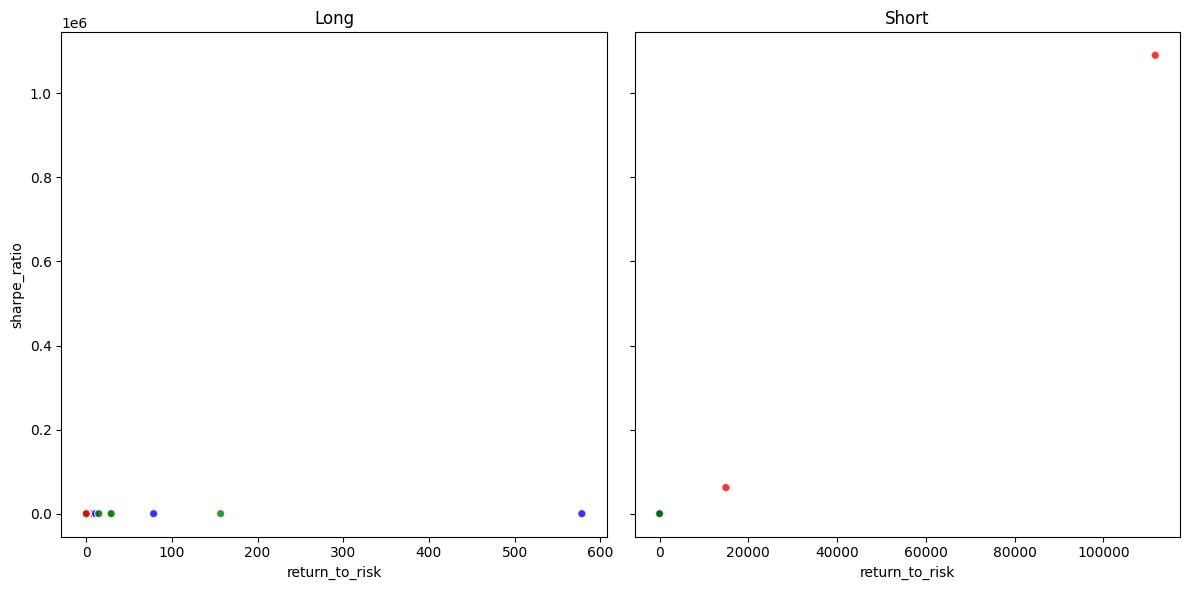

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [31]:
valid = a[(a["timeframe"]=="WEEK") & (a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
62,ema_corr,WEEK,long,OFFICE,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.406530e+01,2.983670e+00,14.768825,1.091156,0.905182,0.557636,1.008888,2.628551,<financial_common.portfolio_management.portfol...,green,2.983670e+00
70,ema_corr,WEEK,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.951598e+01,1.881113e-01,156.906986,1.106919,0.841992,0.661000,1.017109,0.154686,<financial_common.portfolio_management.portfol...,green,1.881113e-01
58,ema_corr,WEEK,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.733897e+00,4.264160e-01,11.101593,1.104426,0.903409,0.502000,1.004319,-0.046011,<financial_common.portfolio_management.portfol...,blue,4.264160e-01
50,ema_corr,WEEK,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.862227e+00,4.265893e+00,0.436539,1.041035,0.958595,0.518826,1.001367,-7.748374,<financial_common.portfolio_management.portfol...,blue,4.265893e+00
54,ema_corr,WEEK,long,SIC_DESCRIPTION,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1.086917e+00,5.848350e+00,0.185850,1.039137,0.960678,0.512883,1.000918,-22.371653,<financial_common.portfolio_management.portfol...,green,5.848350e+00
48,ema_corr,WEEK,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,9.215153e-01,3.427544e+00,0.268856,1.038247,0.959705,0.517401,1.000343,-16.079902,<financial_common.portfolio_management.portfol...,green,3.427544e+00
52,ema_corr,WEEK,long,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,4.243237e-01,1.339852e+00,0.316694,1.035629,0.960816,0.515975,0.999418,-15.220883,<financial_common.portfolio_management.portfol...,red,1.339852e+00
56,ema_corr,WEEK,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3.886727e-02,1.039589e-01,0.373872,1.085859,0.899031,0.508818,0.994093,-13.924095,<financial_common.portfolio_management.portfol...,green,1.039589e-01
66,ema_corr,WEEK,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,6.909175e-04,1.194523e-06,578.404770,1.208048,0.847601,0.482000,1.021337,-0.009066,<financial_common.portfolio_management.portfol...,blue,1.194523e-06
60,ema_corr,WEEK,long,OFFICE,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.850480e-04,1.370683e-03,0.207961,1.069486,0.895275,0.515636,0.985104,-25.218267,<financial_common.portfolio_management.portfol...,red,1.370683e-03


In [32]:
top = valid.head(1).to_dict("records")[0]
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'OFFICE',
 'selection_type': 'long_short',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 44.06529710167339,
 'coefficient_of_variation': 2.9836698165330366,
 'portfolio_std': 14.768824907333869,
 'average_gain': 1.0911560993513276,
 'average_loss': 0.9051824018102442,
 'win_loss_ratio': 0.5576363636363636,
 'weekly_return': 1.008888098239063,
 'sharpe_ratio': 2.628550759563288,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x2556fd012d0>,
 'color': 'green',
 'return_to_risk': 2.9836698165330366}

In [33]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [34]:
trades.columns

Index(['year', 'week', 'ticker', 'date', 'adjclose', 'sell_price', 'office',
       'ema_corr', 'coefficient_of_variation', 'risk', 'group_idx',
       'group_idx_max', 'group_percentile', 'position_type', 'weight',
       'unweighted_return', 'winsorized_return', 'return', 'name',
       'market_cap', 'month', 'quarter'],
      dtype='object')

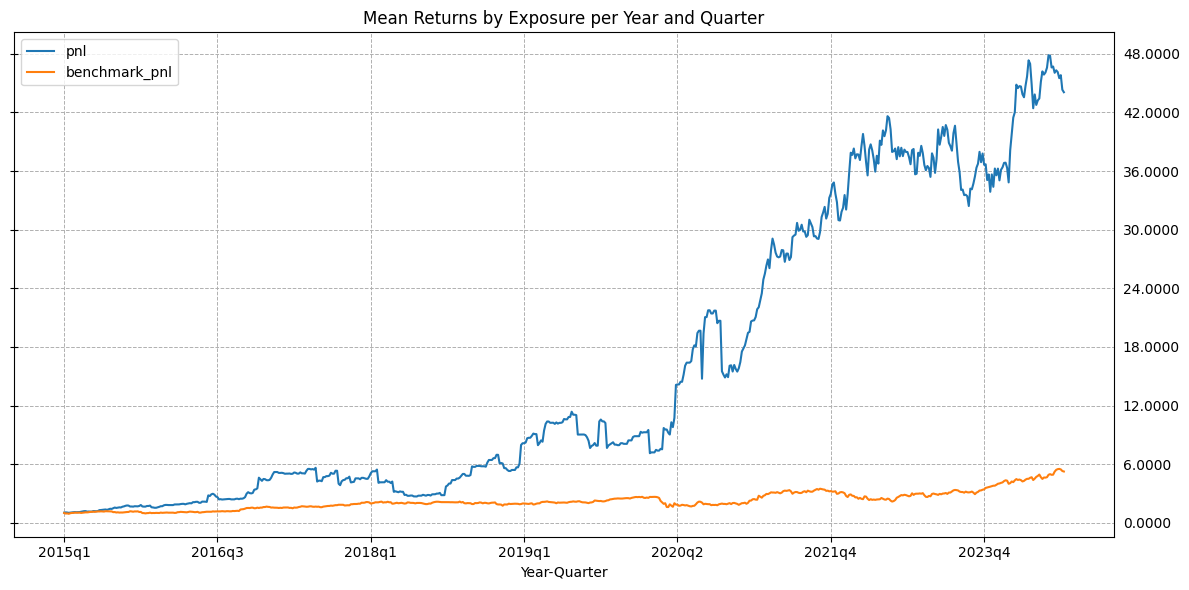

In [35]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [36]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False)

,return
office,
Office of Technology,1.021263
Office of Energy & Transportation,1.014697
Office of Trade & Services,1.013369
Office of Finance,1.009832
Office of Life Sciences,1.009681
Office of Finance or Office of Crypto Assets,1.008752
Office of Trade & Services or Office of Energy & Transportation,1.007892
Office of Manufacturing,1.006785
Industrial Applications and Services,1.003973


In [39]:
trades.sort_values("date",ascending=False).head(20)

,year,week,ticker,date,adjclose,sell_price,office,ema_corr,coefficient_of_variation,risk,...,group_percentile,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
10943,2024,51,REAL,2024-12-20 00:00:00+00:00,9.250000,9.390000,Office of Trade & Services,0.687593,0.442596,0.442596,...,1.000,-1.0,1,0.984865,0.984865,0.984865,"The RealReal, Inc. Common Stock",6.930664e+08,12,4
5434,2024,51,GCTK,2024-12-20 00:00:00+00:00,5.140000,5.870000,Industrial Applications and Services,2.259528,0.551658,0.551658,...,0.002,1.0,1,1.142023,1.142023,1.142023,"GlucoTrack, Inc. Common Stock",4.093736e+06,12,4
10936,2024,51,RKDA,2024-12-20 00:00:00+00:00,6.200000,6.350000,Office of Energy & Transportation,0.681895,0.295470,0.295470,...,1.000,-1.0,1,0.975806,0.975806,0.975806,"Arcadia Biosciences, Inc.",4.447118e+06,12,4
10937,2024,51,FOA,2024-12-20 00:00:00+00:00,24.840000,25.790000,Office of Finance,0.820751,0.430340,0.430340,...,1.000,-1.0,1,0.961755,0.961755,0.961755,Finance of America Companies Inc.,2.104844e+08,12,4
10938,2024,51,EXOD,2024-12-20 00:00:00+00:00,36.680000,41.000000,Office of Finance or Office of Crypto Assets,0.695036,0.292185,0.292185,...,1.000,-1.0,1,0.882225,0.882225,0.882225,"Exodus Movement, Inc.",1.301237e+09,12,4
10939,2024,51,CDIO,2024-12-20 00:00:00+00:00,1.120000,0.973800,Office of Life Sciences,0.457910,0.610448,0.610448,...,1.000,-1.0,1,1.130536,1.130536,1.130536,Cardio Diagnostics Holdings Inc. Common stock,2.523838e+07,12,4
10940,2024,51,AMPG,2024-12-20 00:00:00+00:00,2.730000,1.980000,Office of Manufacturing,0.497590,0.317331,0.317331,...,1.000,-1.0,1,1.274725,1.274725,1.274725,AMPLITECH GROUP INC. COM,3.636908e+07,12,4
10941,2024,51,BEEP,2024-12-20 00:00:00+00:00,4.170000,4.630000,Office of Real Estate & Construction,0.765295,0.097993,0.097993,...,1.000,-1.0,1,0.889688,0.889688,0.889688,Mobile Infrastructure Corporation,1.802808e+08,12,4
10942,2024,51,RGTI,2024-12-20 00:00:00+00:00,8.430000,9.370000,Office of Technology,0.478991,0.977588,0.977588,...,1.000,-1.0,1,0.888493,0.888493,0.888493,"Rigetti Computing, Inc. Common Stock",2.668919e+09,12,4
10944,2024,51,LQDT,2024-12-20 00:00:00+00:00,33.310000,30.960000,Office of Trade & Services or Office of Energy...,0.733386,0.105590,0.105590,...,1.000,-1.0,1,1.070549,1.070549,1.070549,"Liquidity Services, Inc.",9.845668e+08,12,4
